In [1]:
## Full Pipeline Script
# Step 1: Setup and Import Libraries
import mne
import numpy as np
import pandas
# import torch
# import torch.nn as nn
# import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from mne.decoding import CSP
# from mne.time_frequency import psd_multitaper
import pyxdf

import matplotlib.pyplot as plt

[Pipeline of old paper]<img src="pipeline.png" width="800" height="400">

# Functions and definitions

In [2]:
def get_cue_duration(cue_name: str) -> float:
    """TODO: Improve, hardcoded"""
    cue_options = ["pre_cue", "hand", "foot", "pause"]
    
    if cue_name == "pre_cue":
        cue_duration = 2.0
    elif cue_name in ["hand", "foot"]:
        cue_duration = 4.5
    elif cue_name == "pause":
        cue_duration = 2.5
    else:
        raise ValueError(f"Unknown cue name '{cue_name}', choose from: {', '.join(cue_options)}")

    return cue_duration
    

# Processing pipeline

In [3]:
# Load XDF data
file_name = "../Mirage91/Pilot/block_.xdf"
streams, header = pyxdf.load_xdf(file_name)
# streams[1] EEG, streams[2] cues/marker

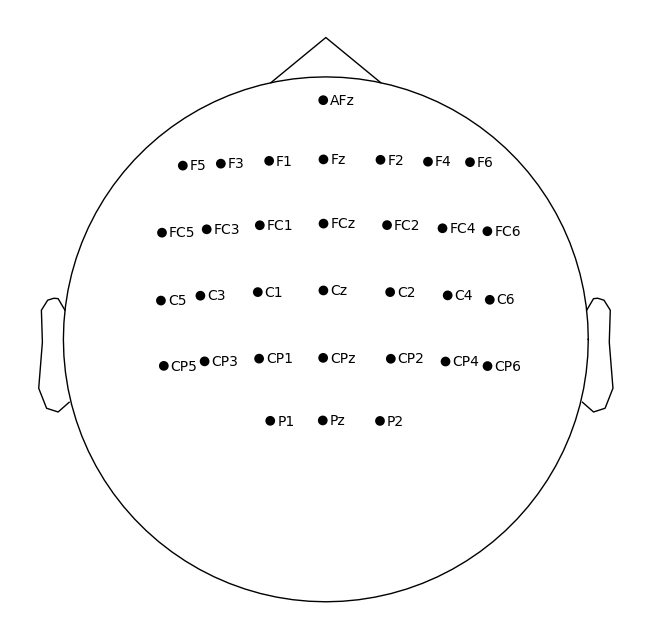

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['foot', 'hand', 'pause', 'pre_cue']


In [4]:
time_buffer = 10  # at the end
eeg_streams = [current_stream for current_stream in streams if current_stream['info']["name"][0] == 'BrainVision RDA']

if len(eeg_streams) == 1:
    eeg_stream = eeg_streams[0]

else:
    raise ValueError()

stim_streams = [current_stream for current_stream in streams if current_stream['info']["name"][0] == 'paradigm']

if len(stim_streams) == 1:
    stim_stream = stim_streams[0]

else:
    raise ValueError()

eeg_info = eeg_stream["info"]

eeg_onset = float(eeg_info["created_at"][0])
cue_onset = float(stim_stream["info"]["created_at"][0])

eeg_first_timestep = float(eeg_stream["footer"]["info"]["first_timestamp"][0])
cue_first_timestep = float(stim_stream["footer"]["info"]["first_timestamp"][0])

if eeg_first_timestep < cue_first_timestep:
    start_of_trial = eeg_first_timestep
else:
    start_of_trial = cue_first_timestep

# f_s = float(eeg_info["nominal_srate"][0])
f_s = float(eeg_info["effective_srate"])

eeg_time_stamps = eeg_stream['time_stamps']
cue_time_stamps = stim_stream['time_stamps']

eeg_time_stamps = eeg_time_stamps - start_of_trial
cue_time_stamps = cue_time_stamps - start_of_trial

last_cue_time_stamp = cue_time_stamps[-1]
end_of_trial_time = last_cue_time_stamp + time_buffer
end_of_trial = np.ceil(end_of_trial_time * f_s).astype(int)

eeg_data = eeg_stream['time_series']
eeg_data = eeg_data.T
eeg_data = eeg_data[:, :end_of_trial]

cue_names = stim_stream['time_series']
cue_names = [element[0] for element in cue_names]
cue_durations = [get_cue_duration(current_cue_name) for current_cue_name in cue_names]
num_channels, num_time_steps = eeg_data.shape

channel_names = [element["label"][0] for element in eeg_info["desc"][0]["channels"][0]["channel"]]

raw = mne.io.RawArray(eeg_data, mne.create_info(
    ch_names=channel_names,
    sfreq=f_s,
    ch_types='eeg'), verbose=False)

raw.drop_channels(['x_dir', 'y_dir', 'z_dir'])
##raw.add_reference_channels("FCz")
raw.set_montage("standard_1020")
raw.plot_sensors(show_names=True)
raw.set_eeg_reference(["AFz"])

annotations = mne.Annotations(onset=cue_time_stamps,
                              duration=cue_durations,
                              description=cue_names)
raw.set_annotations(annotations)

# Step 2: Preprocess Data
# Apply filters

# FIR

raw.filter(1., None, fir_design='firwin', verbose=False)  # Highpass filter at 1 Hz
raw.notch_filter(50., fir_design='firwin', verbose=False)  # Notch filter at 50 Hz
raw.filter(None, 80., fir_design='firwin', verbose=False)  # Anti-aliasing filter at 80 Hz

# IIR

# raw.filter(1., None, method='iir', )  # verbose=False)  # Highpass filter at 1 Hz
# raw.notch_filter(50., method='iir')  # verbose=False)  # Notch filter at 50 Hz
# raw.filter(None, 80., method='iir')  # , verbose=False)  # Anti-aliasing filter at 80 Hz

# Downsample to 250 Hz
raw.resample(250)

#extract events and especially 1 - foot and 2 - hand
all_events, all_event_id = mne.events_from_annotations(raw)
all_events = all_events[np.in1d(all_events[:, 2], (1,2)), :]

In [21]:
print(all_event_id)

{'foot': 1, 'hand': 2, 'pause': 3, 'pre_cue': 4}


Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
0 bad epochs dropped
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


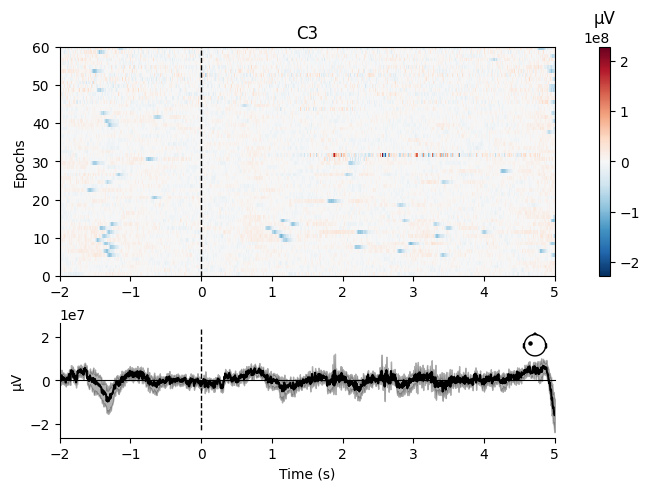

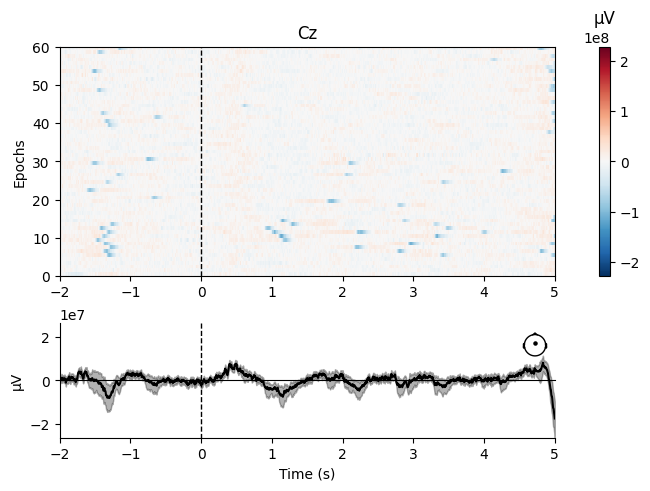

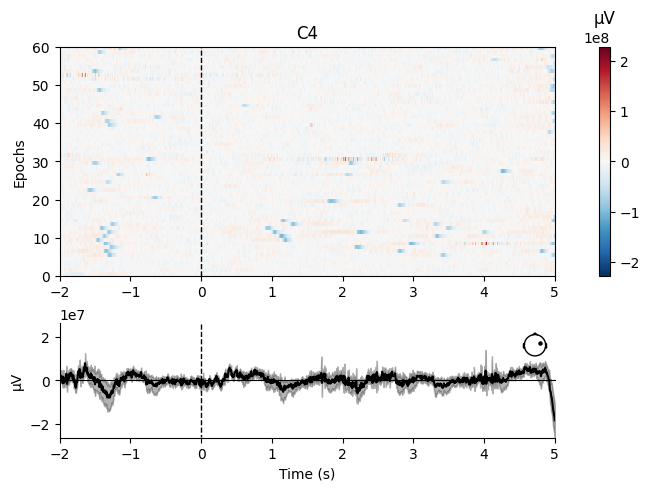

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


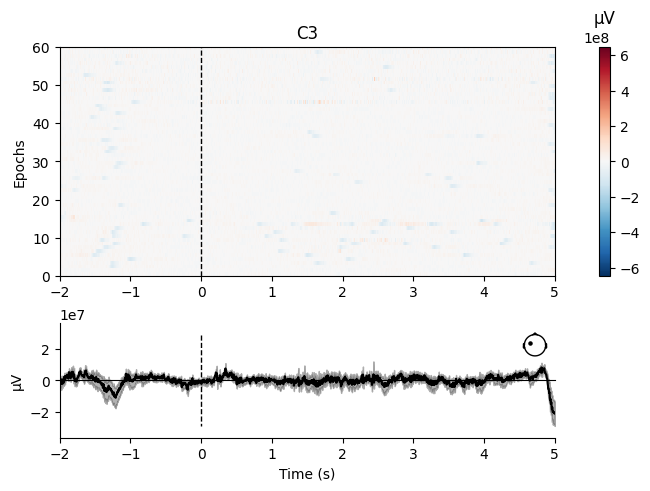

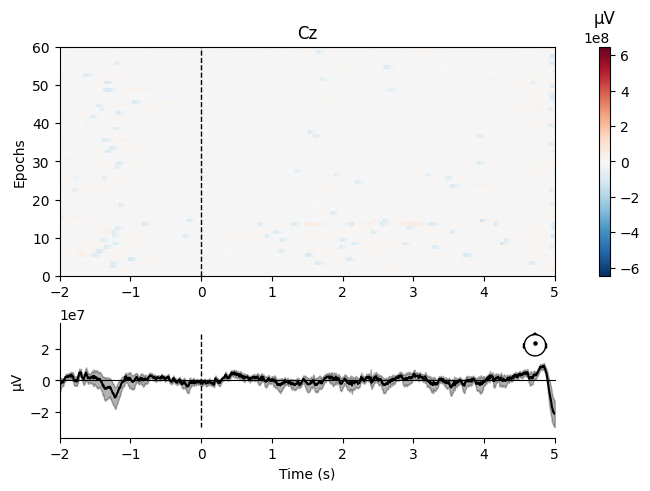

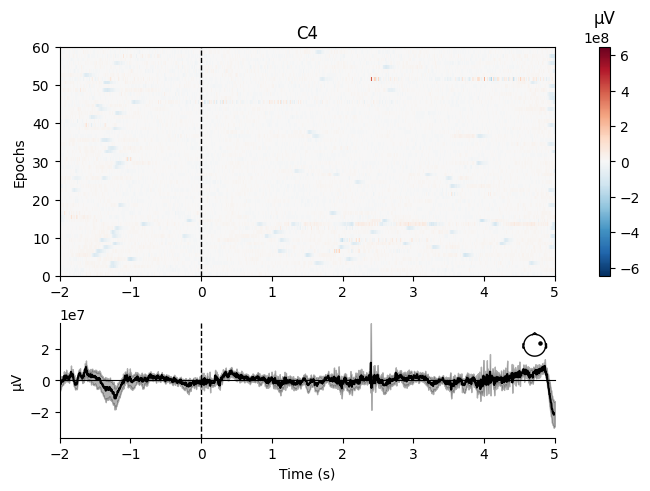

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [46]:
## EPOCHING
tmin, tmax = -2, 5
epochs = mne.Epochs(
    raw,
    all_events,
    dict(foot=all_event_id["foot"], hand=all_event_id["hand"]),
    tmin,
    tmax,
    picks=("C3","C1","Cz","C2","C4"),
    baseline=None,
    preload=True
)

# hand_epochs = epochs["hand"]
# foot_epochs = epochs["foot"]
epochs['foot'].plot_image(picks=["C3", "Cz", "C4"])
epochs['hand'].plot_image(picks=["C3", "Cz", "C4"])

In [ ]:
## CSP FILTERING

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


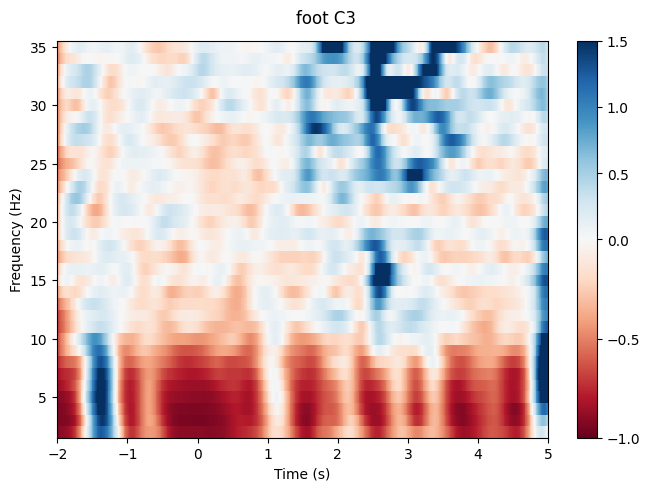

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


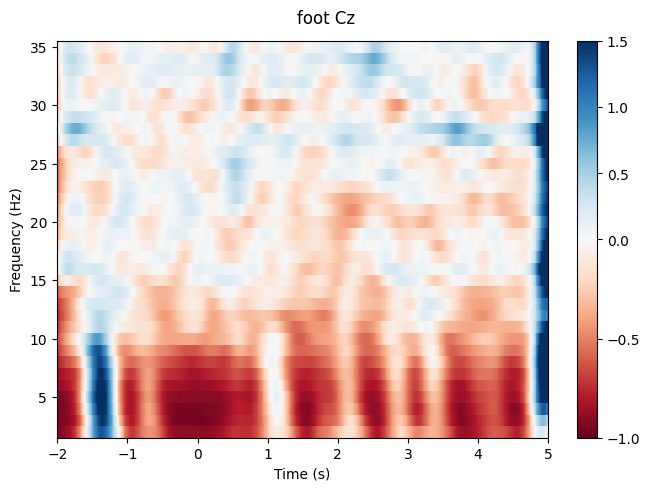

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:16: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)


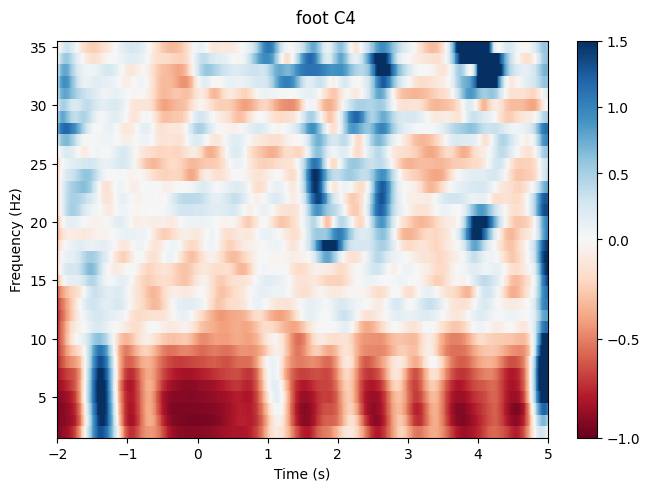

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


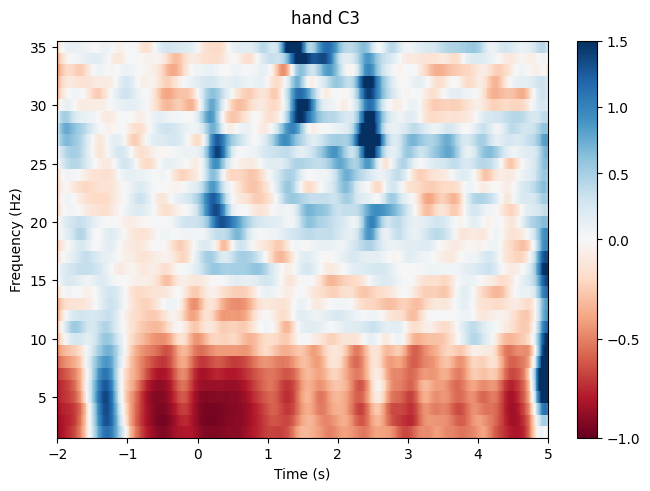

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


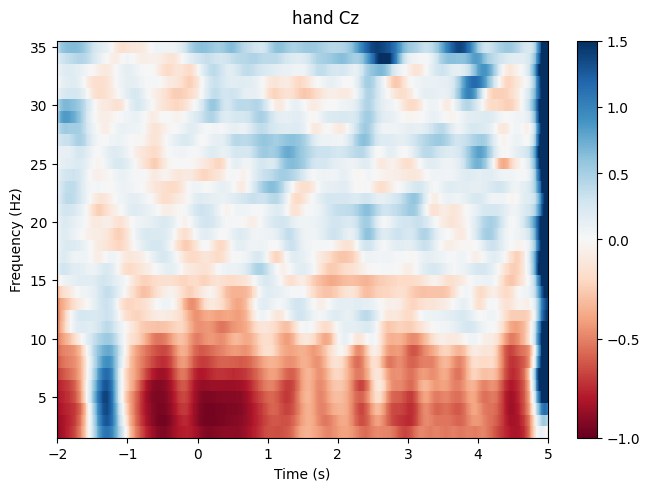

Applying baseline correction (mode: percent)


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3856623676.py:21: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


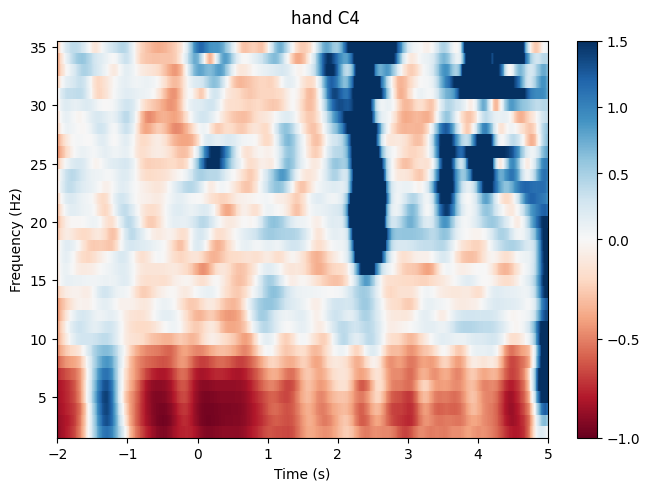

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper
bands = np.array([6,11,8,13, 15,26, 25,36])
freqs = np.arange(2, 36)
baseline = -1.5, -0.5
vmin, vmax = -1, 1.5
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

## ERDS maps foot C3,Cz,C4
chan_of_interest = ["C3","Cz","C4"]
erds_foot = epochs['foot'].compute_tfr('morlet', n_cycles=freqs, return_itc=False, freqs=freqs, decim=3, average=True)
#erds_foot.crop(-1.5,4.5).apply_baseline(baseline,mode="percent")
#erds_foot.plot(["C3","Cz","C4"])
for i in chan_of_interest:
    erds_foot.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="foot "+i, show=True, verbose=True)

# ## ERDS map hand C3,Cz,C4
erds_hand = epochs['hand'].compute_tfr('morlet', n_cycles=freqs, return_itc=False, freqs=freqs, decim=3, average=True)
for i in chan_of_interest:
    erds_hand.plot(picks=i,tmin=tmin, tmax=tmax, fmin=0.0, fmax=freqs[-1], baseline=baseline, mode='percent', vmin=vmin, vmax=vmax, cnorm=cnorm, cmap='RdBu', colorbar=True, title="hand "+i, show=True, verbose=True)


In [ ]:
## OR in one plot together:
for event in epochs.event_id:  # for each condition
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    tfr, itc = tfr_multitaper(epochs[event], freqs=freqs, n_cycles=freqs)
    tfr.crop(-1.5, 4.5).apply_baseline(baseline, mode="percent")
    itc.crop(-1.5, 4.5)
    tfr.plot(
        vmin=vmin,
        vmax=vmax,
        title=event,
        axes=axes,
        cmap="RdBu",
        cnorm=cnorm,
        show=False
    )
    for i, ax in enumerate(axes):
        ax.set_title(epochs.info["ch_names"][i])
plt.show()

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
0 bad epochs dropped


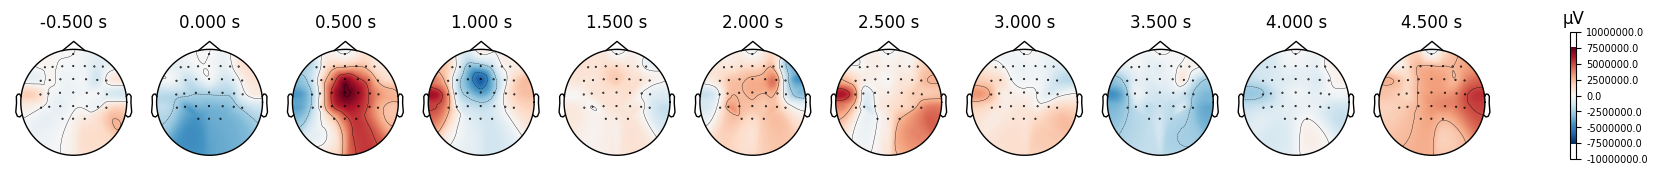

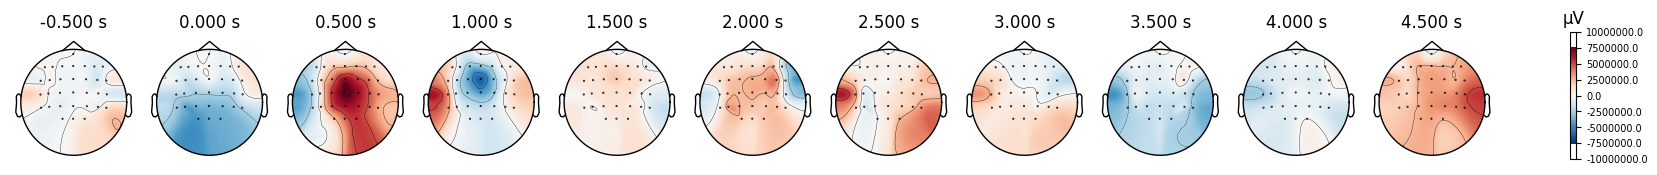

In [52]:
## TOPOPLOT USING AGAIN ALL CHANNELS
## maybe good to improve classification among different classes if time is changing
epochs = mne.Epochs(
    raw,
    all_events,
    dict(foot=all_event_id["foot"], hand=all_event_id["hand"]),
    tmin,
    tmax,
    baseline=None,
    preload=True
)
# otherwise add above: picks=("C3","C1","Cz","C2","C4") 
epochs["foot"].average().plot_topomap(times=[-0.5, 0.0, 0.5, 1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5], ch_type="eeg")

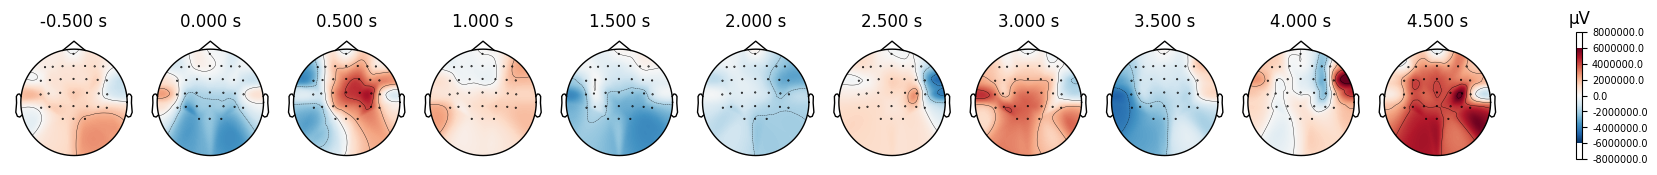

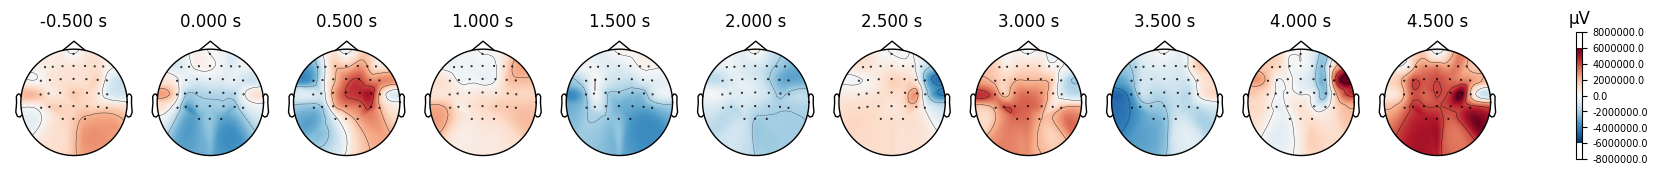

In [53]:
epochs["hand"].average().plot_topomap(times=[-0.5, 0.0, 0.5, 1., 1.5, 2, 2.5, 3., 3.5, 4., 4.5], ch_type="eeg")

In [6]:
## START Training

X = epochs.get_data()
y = epochs.events[:, 2]

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 2001 original time points ...
0 bad epochs dropped


C:\Users\michi\AppData\Local\Temp\ipykernel_12520\3537166589.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [ ]:
# Step 3: Create Feature Bands and Epoching
# Define frequency bands
bands = {
    "6-10": (6, 10),
    "8-12": (8, 12),
    "15-25": (15, 25),
    "25-35": (25, 35)
}

# # Epoch the data
# events = mne.find_events(raw)
# event_id = dict(class_1=1, class_2=2, class_3=3, class_4=4, class_5=5, class_6=6, class_7=7)
# epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)

# # Step 4: Artifact Rejection
# reject_criteria = dict(eeg=100e-6)  # 100 µV
# epochs.drop_bad(reject=reject_criteria)

# # Step 5: Spatial Filtering with CSP
# csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
# csp.fit_transform(epochs.get_data(), epochs.events[:, -1])

# # Step 6: Extract Bandpower Features
# def compute_bandpower(data, sf, band, window_sec=None, relative=False):
#     band = np.asarray(band)
#     low, high = band

#     psd, freqs = psd_multitaper(data, sf, fmin=low, fmax=high, adaptive=True, normalization='full', verbose=0)
#     psd = psd.mean(axis=0)

#     bp = np.trapz(psd, freqs)

#     if relative:
#         bp /= np.trapz(psd, freqs)

#     return bp

# sfreq = raw.info['sfreq']
# X = []
# for band in bands.values():
#     X.append(compute_bandpower(epochs.get_data(), sfreq, band))

# X = np.stack(X, axis=-1)
# y = epochs.events[:, -1]

# Tests

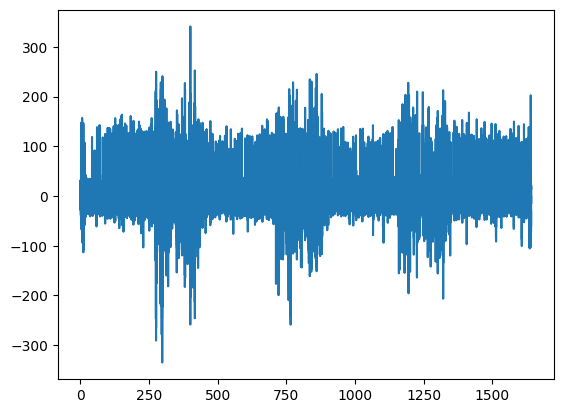

In [5]:
current_data, time_vector = raw["data"]
channel_index = 0
current_channel_data = current_data[channel_index]

plt.plot(time_vector, current_channel_data)
plt.show()

Using matplotlib as 2D backend.


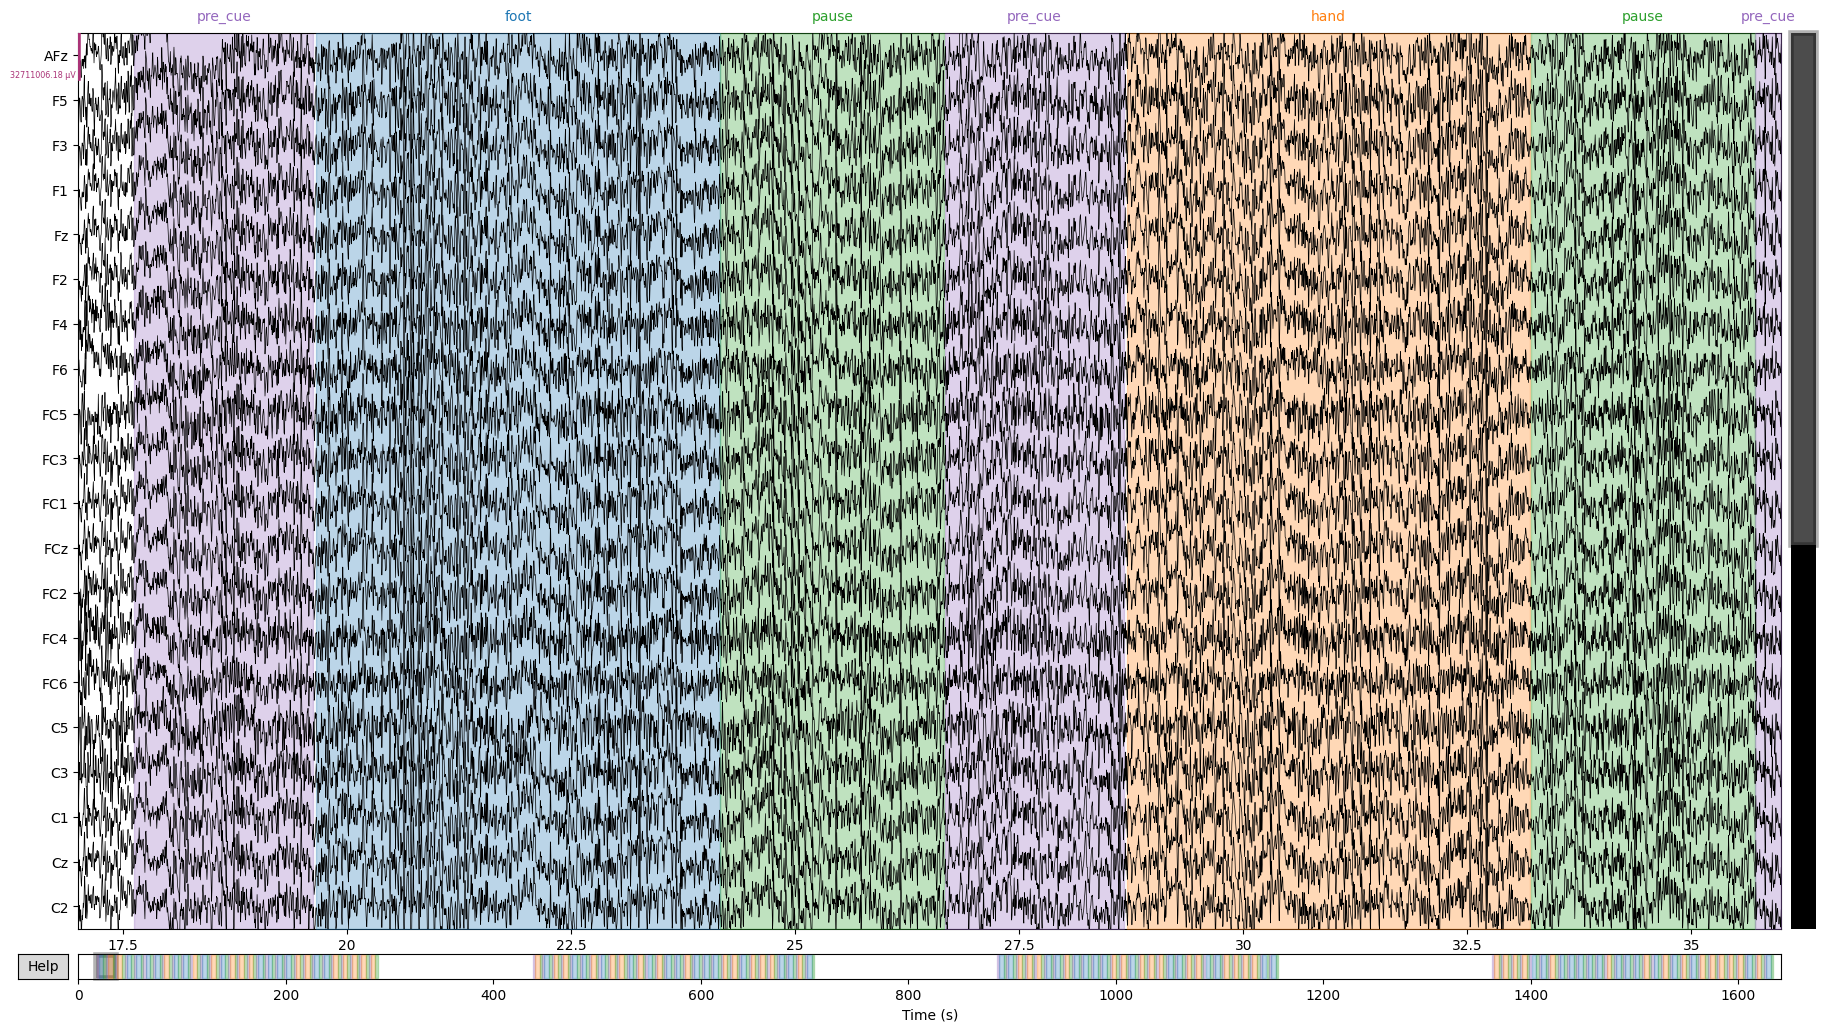

In [6]:
fig = raw.plot(start=17, duration=19, scalings="auto")